In [1]:

#!/usr/bin/env python
import copy
import torch
import argparse
import os
import time
import warnings
import numpy as np
import torchvision
import logging

from flcore.servers.serveravg import FedAvg
from flcore.servers.serverpFedMe import pFedMe
from flcore.servers.serverperavg import PerAvg
from flcore.servers.serverprox import FedProx
from flcore.servers.serverfomo import FedFomo
from flcore.servers.serveramp import FedAMP
from flcore.servers.servermtl import FedMTL
from flcore.servers.serverlocal import Local
from flcore.servers.serverper import FedPer
from flcore.servers.serverapfl import APFL
from flcore.servers.serverditto import Ditto
from flcore.servers.serverrep import FedRep
from flcore.servers.serverphp import FedPHP
from flcore.servers.serverbn import FedBN
from flcore.servers.serverrod import FedROD
from flcore.servers.serverproto import FedProto
from flcore.servers.serverdyn import FedDyn
from flcore.servers.servermoon import MOON
from flcore.servers.serverbabu import FedBABU
from flcore.servers.serverapple import APPLE
from flcore.servers.serverfedtrans import FedTrans 

from flcore.trainmodel.models import *

from flcore.trainmodel.bilstm import BiLSTM_TextClassification
# from flcore.trainmodel.resnet import resnet18 as resnet
from flcore.trainmodel.alexnet import alexnet
from flcore.trainmodel.mobilenet_v2 import mobilenet_v2
from utils.result_utils import average_data
from utils.mem_utils import MemReporter

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

warnings.simplefilter("ignore")
torch.manual_seed(0)

# hyper-params for Text tasks
vocab_size = 98635
max_len=200
hidden_dim=32

def run(args):

    time_list = []
    reporter = MemReporter()
    model_str = args.model

    for i in range(args.prev, args.times):
        print(f"\n============= Running time: {i}th =============")
        print("Creating server and clients ...")
        start = time.time()

        # Generate args.model
        if model_str == "mlr":
            if args.dataset == "mnist" or args.dataset == "fmnist":
                args.model = Mclr_Logistic(1*28*28, num_classes=args.num_classes).to(args.device)
            elif args.dataset == "Cifar10" or args.dataset == "Cifar100":
                args.model = Mclr_Logistic(3*32*32, num_classes=args.num_classes).to(args.device)
            else:
                args.model = Mclr_Logistic(60, num_classes=args.num_classes).to(args.device)

        elif model_str == "cnn":
            if args.dataset[:5] == "mnist" or args.dataset == "fmnist":
                args.model = FedAvgCNN(in_features=1, num_classes=args.num_classes, dim=1024).to(args.device)
            elif args.dataset == "omniglot":
                args.model = FedAvgCNN(in_features=1, num_classes=args.num_classes, dim=33856).to(args.device)
            elif args.dataset[:5] == "Cifar":
                args.model = FedAvgCNN(in_features=3, num_classes=args.num_classes, dim=1600).to(args.device)
                # args.model = CifarNet(num_classes=args.num_classes).to(args.device)
            elif args.dataset == "Digit5":
                args.model = Digit5CNN().to(args.device)
            else:
                args.model = FedAvgCNN(in_features=3, num_classes=args.num_classes, dim=10816).to(args.device)

        elif model_str == "dnn": # non-convex
            if args.dataset == "mnist" or args.dataset == "fmnist":
                args.model = DNN(1*28*28, 100, num_classes=args.num_classes).to(args.device)
            elif args.dataset == "Cifar10" or args.dataset == "Cifar100":
                args.model = DNN(3*32*32, 100, num_classes=args.num_classes).to(args.device)
            else:
                args.model = DNN(60, 20, num_classes=args.num_classes).to(args.device)
        
        elif model_str == "resnet":
            args.model = torchvision.models.resnet18(pretrained=False, num_classes=args.num_classes).to(args.device)
            
            # args.model = torchvision.models.resnet18(pretrained=True).to(args.device)
            # feature_dim = list(args.model.fc.parameters())[0].shape[1]
            # args.model.fc = nn.Linear(feature_dim, args.num_classes).to(args.device)
            
            # args.model = resnet18(num_classes=args.num_classes, has_bn=True, bn_block_num=4).to(args.device)

        elif model_str == "alexnet":
            args.model = alexnet(pretrained=False, num_classes=args.num_classes).to(args.device)
            
            # args.model = alexnet(pretrained=True).to(args.device)
            # feature_dim = list(args.model.fc.parameters())[0].shape[1]
            # args.model.fc = nn.Linear(feature_dim, args.num_classes).to(args.device)
            
        elif model_str == "googlenet":
            args.model = torchvision.models.googlenet(pretrained=False, aux_logits=False, num_classes=args.num_classes).to(args.device)
            
            # args.model = torchvision.models.googlenet(pretrained=True, aux_logits=False).to(args.device)
            # feature_dim = list(args.model.fc.parameters())[0].shape[1]
            # args.model.fc = nn.Linear(feature_dim, args.num_classes).to(args.device)

        elif model_str == "mobilenet_v2":
            args.model = mobilenet_v2(pretrained=False, num_classes=args.num_classes).to(args.device)
            
            # args.model = mobilenet_v2(pretrained=True).to(args.device)
            # feature_dim = list(args.model.fc.parameters())[0].shape[1]
            # args.model.fc = nn.Linear(feature_dim, args.num_classes).to(args.device)
            
        elif model_str == "lstm":
            args.model = LSTMNet(hidden_dim=hidden_dim, vocab_size=vocab_size, num_classes=args.num_classes).to(args.device)

        elif model_str == "bilstm":
            args.model = BiLSTM_TextClassification(input_size=vocab_size, hidden_size=hidden_dim, output_size=args.num_classes, 
                        num_layers=1, embedding_dropout=0, lstm_dropout=0, attention_dropout=0, 
                        embedding_length=hidden_dim).to(args.device)

        elif model_str == "fastText":
            args.model = fastText(hidden_dim=hidden_dim, vocab_size=vocab_size, num_classes=args.num_classes).to(args.device)

        elif model_str == "TextCNN":
            args.model = TextCNN(hidden_dim=hidden_dim, max_len=max_len, vocab_size=vocab_size, 
                            num_classes=args.num_classes).to(args.device)

        elif model_str == "Transformer":
            args.model = TransformerModel(ntoken=vocab_size, d_model=hidden_dim, nhead=2, d_hid=hidden_dim, nlayers=2, 
                            num_classes=args.num_classes).to(args.device)
        
        elif model_str == "AmazonMLP":
            args.model = AmazonMLP().to(args.device)

        else:
            raise NotImplementedError

        print(args.model)

        # select algorithm
        if args.algorithm == "FedAvg":
            server = FedAvg(args, i)

        elif args.algorithm == "Local":
            server = Local(args, i)

        elif args.algorithm == "FedMTL":
            server = FedMTL(args, i)

        elif args.algorithm == "PerAvg":
            server = PerAvg(args, i)

        elif args.algorithm == "pFedMe":
            server = pFedMe(args, i)

        elif args.algorithm == "FedProx":
            server = FedProx(args, i)

        elif args.algorithm == "FedFomo":
            server = FedFomo(args, i)

        elif args.algorithm == "FedAMP":
            server = FedAMP(args, i)

        elif args.algorithm == "APFL":
            server = APFL(args, i)

        elif args.algorithm == "FedPer":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedPer(args, i)

        elif args.algorithm == "Ditto":
            server = Ditto(args, i)

        elif args.algorithm == "FedRep":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedRep(args, i)

        elif args.algorithm == "FedPHP":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedPHP(args, i)

        elif args.algorithm == "FedBN":
            server = FedBN(args, i)

        elif args.algorithm == "FedROD":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedROD(args, i)

        elif args.algorithm == "FedProto":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedProto(args, i)

        elif args.algorithm == "FedDyn":
            server = FedDyn(args, i)

        elif args.algorithm == "MOON":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = MOON(args, i)

        elif args.algorithm == "FedBABU":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedBABU(args, i)

        elif args.algorithm == "APPLE":
            server = APPLE(args, i)
            
        elif args.algorithm == "FedTrans":
            args.head = copy.deepcopy(args.model.fc)
            args.model.fc = nn.Identity()
            args.model = LocalModel(args.model, args.head)
            server = FedTrans(args, i)
            
        else:
            raise NotImplementedError
    
    return server

if __name__ == "__main__":
    total_start = time.time()

    parser = argparse.ArgumentParser()
    # general
    parser.add_argument('-go', "--goal", type=str, default="test", 
                        help="The goal for this experiment")
    parser.add_argument('-dev', "--device", type=str, default="cuda",
                        choices=["cpu", "cuda"])
    parser.add_argument('-did', "--device_id", type=str, default="0")
    parser.add_argument('-data', "--dataset", type=str, default="mnist")
    parser.add_argument('-nb', "--num_classes", type=int, default=10)
    parser.add_argument('-m', "--model", type=str, default="cnn")
    parser.add_argument('-p', "--head", type=str, default="cnn")
    parser.add_argument('-lbs', "--batch_size", type=int, default=10)
    parser.add_argument('-lr', "--local_learning_rate", type=float, default=0.005,
                        help="Local learning rate")
    parser.add_argument('-gr', "--global_rounds", type=int, default=1000)
    parser.add_argument('-ls', "--local_steps", type=int, default=1)
    parser.add_argument('-algo', "--algorithm", type=str, default="FedAvg")
    parser.add_argument('-jr', "--join_ratio", type=float, default=1.0,
                        help="Ratio of clients per round")
    parser.add_argument('-rjr', "--random_join_ratio", type=bool, default=False,
                        help="Random ratio of clients per round")
    parser.add_argument('-nc', "--num_clients", type=int, default=2,
                        help="Total number of clients")
    parser.add_argument('-pv', "--prev", type=int, default=0,
                        help="Previous Running times")
    parser.add_argument('-t', "--times", type=int, default=1,
                        help="Running times")
    parser.add_argument('-eg', "--eval_gap", type=int, default=1,
                        help="Rounds gap for evaluation")
    parser.add_argument('-dp', "--privacy", type=bool, default=False,
                        help="differential privacy")
    parser.add_argument('-dps', "--dp_sigma", type=float, default=0.0)
    parser.add_argument('-sfn', "--save_folder_name", type=str, default='models')
    # practical
    parser.add_argument('-cdr', "--client_drop_rate", type=float, default=0.0,
                        help="Rate for clients that train but drop out")
    parser.add_argument('-tsr', "--train_slow_rate", type=float, default=0.0,
                        help="The rate for slow clients when training locally")
    parser.add_argument('-ssr', "--send_slow_rate", type=float, default=0.0,
                        help="The rate for slow clients when sending global model")
    parser.add_argument('-ts', "--time_select", type=bool, default=False,
                        help="Whether to group and select clients at each round according to time cost")
    parser.add_argument('-tth', "--time_threthold", type=float, default=10000,
                        help="The threthold for droping slow clients")
    # pFedMe / PerAvg / FedProx / FedAMP / FedPHP
    parser.add_argument('-bt', "--beta", type=float, default=0.0,
                        help="Average moving parameter for pFedMe, Second learning rate of Per-FedAvg, \
                        or L1 regularization weight of FedTransfer")
    parser.add_argument('-lam', "--lamda", type=float, default=1.0,
                        help="Regularization weight for pFedMe and FedAMP")
    parser.add_argument('-mu', "--mu", type=float, default=0,
                        help="Proximal rate for FedProx")
    parser.add_argument('-K', "--K", type=int, default=5,
                        help="Number of personalized training steps for pFedMe")
    parser.add_argument('-lrp', "--p_learning_rate", type=float, default=0.01,
                        help="personalized learning rate to caculate theta aproximately using K steps")
    # FedFomo
    parser.add_argument('-M', "--M", type=int, default=5,
                        help="Server only sends M client models to one client at each round")
    # FedMTL
    parser.add_argument('-itk', "--itk", type=int, default=4000,
                        help="The iterations for solving quadratic subproblems")
    # FedAMP
    parser.add_argument('-alk', "--alphaK", type=float, default=1.0, 
                        help="lambda/sqrt(GLOABL-ITRATION) according to the paper")
    parser.add_argument('-sg', "--sigma", type=float, default=1.0)
    # APFL
    parser.add_argument('-al', "--alpha", type=float, default=1.0)
    # Ditto / FedRep
    parser.add_argument('-pls', "--plocal_steps", type=int, default=1)
    # MOON
    parser.add_argument('-ta', "--tau", type=float, default=1.0)
    # FedBABU
    parser.add_argument('-fts', "--fine_tuning_steps", type=int, default=1)
    # APPLE
    parser.add_argument('-dlr', "--dr_learning_rate", type=float, default=0.0)
    parser.add_argument('-L', "--L", type=float, default=1.0)
    #FedTrans
    parser.add_argument('-ere', "--every_recluster_eps", type=int, default=5)
    parser.add_argument('-ed', "--emb_dim", type=int, default=128)
    parser.add_argument('-alr', "--attn_learning_rate", type=float, default=0.005)
    parser.add_argument('-ncl', "--num_cluster", type=int, default=10)

    
    args = parser.parse_args(args=["-data","mnist", "-m", "cnn", -algo FedTrans -gr 2500 -did 0 -go cnn -nc 2")
    os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id

    if args.device == "cuda" and not torch.cuda.is_available():
        print("\ncuda is not avaiable.\n")
        args.device = "cpu"

    print("=" * 50)

    print("Algorithm: {}".format(args.algorithm))
    print("Local batch size: {}".format(args.batch_size))
    print("Local steps: {}".format(args.local_steps))
    print("Local learing rate: {}".format(args.local_learning_rate))
    print("Total number of clients: {}".format(args.num_clients))
    print("Clients join in each round: {}".format(args.join_ratio))
    print("Client drop rate: {}".format(args.client_drop_rate))
    print("Time select: {}".format(args.time_select))
    print("Time threthold: {}".format(args.time_threthold))
    print("Global rounds: {}".format(args.global_rounds))
    print("Running times: {}".format(args.times))
    print("Dataset: {}".format(args.dataset))
    print("Local model: {}".format(args.model))
    print("Using device: {}".format(args.device))

    if args.device == "cuda":
        print("Cuda device id: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))
    print("=" * 50)


    # if args.dataset == "mnist" or args.dataset == "fmnist":
    #     generate_mnist('../dataset/mnist/', args.num_clients, 10, args.niid)
    # elif args.dataset == "Cifar10" or args.dataset == "Cifar100":
    #     generate_cifar10('../dataset/Cifar10/', args.num_clients, 10, args.niid)
    # else:
    #     generate_synthetic('../dataset/synthetic/', args.num_clients, 10, args.niid)

    # with torch.profiler.profile(
    #     activities=[
    #         torch.profiler.ProfilerActivity.CPU,
    #         torch.profiler.ProfilerActivity.CUDA],
    #     profile_memory=True, 
    #     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    #     ) as prof:
    # with torch.autograd.profiler.profile(profile_memory=True) as prof:
    server = run(args)

    
    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))
    # print(f"\nTotal time cost: {round(time.time()-total_start, 2)}s.")


SyntaxError: invalid syntax (Temp/ipykernel_34524/1273866419.py, line 332)

In [12]:
import torch
res = torch.load("cel.pt")
emb_list, weights = res
print(emb_list, weights)

[tensor([[-0.0203,  0.0265,  0.0265,  0.0092,  0.0197,  0.0188,  0.0240, -0.0010,
         -0.0064, -0.0164,  0.0229,  0.0131,  0.0095, -0.0219, -0.0100, -0.0188,
          0.0344,  0.0322,  0.0388, -0.0056,  0.0178,  0.0253,  0.0166,  0.0336,
          0.0009,  0.0038,  0.0136, -0.0013,  0.0142,  0.0146, -0.0167,  0.0278,
         -0.0181, -0.0092,  0.0094,  0.0225,  0.0055, -0.0187,  0.0293,  0.0201,
         -0.0229, -0.0218, -0.0211,  0.0274, -0.0080,  0.0148, -0.0203, -0.0275,
         -0.0081,  0.0107,  0.0158,  0.0093, -0.0247, -0.0167,  0.0544, -0.0046,
          0.0095, -0.0067, -0.0074,  0.0156,  0.0085,  0.0234, -0.0052,  0.0204,
         -0.0222,  0.0008,  0.0158, -0.0140,  0.0019,  0.0103, -0.0138, -0.0159,
         -0.0168,  0.0061, -0.0049, -0.0009,  0.0071, -0.0128,  0.0130, -0.0022,
          0.0123, -0.0407,  0.0122,  0.0169, -0.0096, -0.0321,  0.0036,  0.0004,
          0.0094,  0.0029,  0.0042,  0.0099, -0.0069,  0.0014, -0.0162, -0.0421,
          0.0053, -0.0012, 

In [13]:
print(weights.size())

torch.Size([10, 10])


In [14]:

x = torch.cat(emb_list, dim=0).squeeze(1)
print(x.size())

torch.Size([10, 128])


In [9]:
from flcore.servers.serverfedtrans import Attn_Model
device = "cuda:0"
x.to(device)
attn_model = Attn_Model().to(device)
weights = attn_model(x)

In [26]:
psub_res = torch.load("psub_res.pth")
def cosine_similarity(a, b):
    dot_product = torch.dot(a, b)
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    return dot_product / (norm_a * norm_b)

print(cosine_similarity(psub_res[1],psub_res[0]))

tensor(0.0204, device='cuda:0')


In [27]:
print(psub_res[0].size())

torch.Size([10100])


In [15]:
attn_model = torch.load("models\Cifar10\FedTrans_server_attn.pt")
intra_attn_model = attn_model['intra_attn_model']

psub_res = [p.unsqueeze(0) for p in psub_res]

x = torch.cat(psub_res, dim=0)

In [25]:
print(x.size())

torch.Size([20, 10100])


In [23]:
from flcore.servers.serverfedtrans import Attn_Model
attn_model2 = Attn_Model()

In [32]:
for name, param in emb_layer.named_parameters():
    print(f"Layer: {name}, Size: {param.size()}")

Layer: weight, Size: torch.Size([1024, 10100])
Layer: bias, Size: torch.Size([1024])


In [31]:
emb_layer = nn.Linear(x.size(1),intra_attn_model.query.weight.size(0))

In [ ]:
emb_list = [psub for psub in psub_res]

In [ ]:
iter_e, iter_w = res['inter_clusters_res']

In [ ]:
print(iter_e[1].size())

x = torch.cat(iter_e, dim=0).squeeze(1)

In [ ]:
print(x)

In [ ]:
import torch
from torch import nn

class Attn_Model_C(nn.Module):
    def __init__(self, emb_dim=128, attn_dim=128, num_heads=8):
        super(Attn_Model_C, self).__init__()
        self.emb_dim = emb_dim
        self.attn_dim = attn_dim
        self.query = nn.Linear(emb_dim, attn_dim)
        self.key = nn.Linear(emb_dim, attn_dim)
        #self.inter_LN = nn.LayerNorm(attn_dim)

        # 1-layer attention for simple verify

    def forward(self, x, models=None, prev_models=None):
        #x = self.inter_LN(x) 
        q = self.query(x)

        k = self.key(x)
        print("q:{}\n{}\nk:{}".format(q,"-"*5,k))
        scores = torch.matmul(q, k.transpose(-2, -1)) 
        #scores = torch.matmul(q, k.transpose(-2, -1)) / (self.attn_dim ** 0.2)
        print(scores)
        attention_weights = torch.softmax(scores, dim=-1)
        return attention_weights

In [ ]:

attn_model_1 = Attn_Model_C().to(device)
w = attn_model(x.to(device))

print(w)

In [ ]:
for c in res['intra_clusters_res']:
    if c is not None:
        c_e = c[0]
    else:
        continue
    
    x = torch.cat(c_e, dim=0).squeeze(1)
    w = attn_model_1(x.to(device))
    print(w)

In [ ]:

print(res['intra_clusters_res'][1])

In [ ]:
import torch
model = torch.load("gm_avg.pt")

In [ ]:
import copy
ps = []
param = [p.view(-1) for p in model.parameters()]
ps = torch.concat(param, dim=0)

In [ ]:
ps.size()

In [ ]:
ps[0]

## 测试attn参数backward

#### 开始

In [1]:
import torch
from torch import nn

model1 = torch.nn.Linear(10, 20)
model2 = torch.nn.Linear(10, 20)
emb_layer = torch.nn.Linear(220, 128)
for p_1, p_2 in zip(model1.parameters(), model2.parameters()):
    p_1.data += p_2.data
loss = nn.MSELoss()

In [2]:
from collections import OrderedDict

model1 = torch.nn.Linear(10, 20)
model2 = torch.nn.Linear(10, 20)
sd1 = model1.state_dict()
sd2 = model2.state_dict()
sd3 = OrderedDict()
for name, param in model1.named_parameters():
    sd3[name] = param.data.clone()
print("sd1:{}\nsd3:{}".format(sd1,sd3))
#for name, param in model1.named_parameters():
#    sd2[name] = param.data


sd1:OrderedDict([('weight', tensor([[-0.2774, -0.2567, -0.1063,  0.2227,  0.2273, -0.2888, -0.0162, -0.2818,
         -0.2191, -0.2335],
        [-0.1504, -0.0964,  0.2403,  0.2067, -0.0128, -0.0865,  0.0328,  0.2412,
         -0.2551, -0.2395],
        [ 0.0140, -0.0507, -0.2754, -0.2450,  0.0605,  0.3154, -0.1677,  0.0574,
         -0.0959, -0.1168],
        [-0.1130, -0.2067, -0.1491, -0.1524,  0.0207,  0.0843,  0.2871, -0.2830,
         -0.1689,  0.2578],
        [ 0.1576, -0.0371, -0.0695, -0.2472,  0.2229,  0.1555, -0.1405, -0.1537,
         -0.0910,  0.1616],
        [-0.0249, -0.2841,  0.2248, -0.2295, -0.1144,  0.1063, -0.2562, -0.0930,
         -0.2208,  0.0830],
        [ 0.0579, -0.0092,  0.3107,  0.2145,  0.0440,  0.2182, -0.0439,  0.0309,
         -0.1744, -0.2256],
        [-0.1732, -0.3109,  0.2855,  0.2518,  0.0639, -0.2686, -0.0803,  0.2862,
          0.2051, -0.0335],
        [-0.0442,  0.0963,  0.0724,  0.1717, -0.0988, -0.2718, -0.0267,  0.0407,
          0.3117,  

In [ ]:
class Attn_Model(nn.Module):
    def __init__(self, emb_dim=128, attn_dim=128, num_heads=8):
        super(Attn_Model, self).__init__()
        self.emb_dim = emb_dim
        self.attn_dim = attn_dim
        self.query = nn.Linear(emb_dim, attn_dim)
        self.key = nn.Linear(emb_dim, attn_dim)
        #self.inter_LN = nn.LayerNorm(attn_dim)

        # 1-layer attention for simple verify

    def forward(self, x, models=None, prev_models=None):
        #x = self.inter_LN(x) 
        q = self.query(x)
        k = self.key(x)

        scores = torch.matmul(q, k.transpose(-2, -1)) 

        #scaled coef removed since we want to diff weight matrix entries
        #scores = torch.matmul(q, k.transpose(-2, -1)) / (self.attn_dim ** 0.5)
        attention_weights = torch.softmax(scores, dim=-1)
        return attention_weights

In [ ]:

import copy

##
def w_add_params(global_model, m_weights, models_params, require_grad=False):
    params = [] 
    res = copy.deepcopy(global_model)
    for param in res.parameters():
        param.data.zero_()
            
    for w, model_params in zip(m_weights, models_params):
        for res_param, model_param in zip(res.parameters(), model_params):
            if require_grad:
                res_param.grad += model_param.grad.clone().detach() * w
            res_param.data += model_param.data.clone().detach() * w
    return res
        
        

def emb(phead,emb_layer):
    params = []
    for p in phead.parameters():
        params.append(p.flatten())
    params = torch.cat(params)
    return emb_layer(params)


def weight_flatten(model):
    params = []
    for u in model.parameters():
        params.append(u.view(-1))
    params = torch.cat(params)

    return params

### 创建模型以及计算weighted sum

In [ ]:
models = [nn.Linear(10,20) for i in range(10)]
flatten_models = [weight_flatten(model) for model in models]
emb_layer = nn.Linear(len(flatten_models[0]), 128)
models_emb = [emb(model, emb_layer) for model in models]


In [ ]:
x = torch.cat([e.reshape(1,-1) for e in models_emb], dim=0)
print(x.size())

In [ ]:
attn_model = Attn_Model()

weights = attn_model(x)
print(weights)

#### 暂时关闭

In [ ]:
new_ms = []
for i in range(weights.size()[0]):
    w = [weights[i][j] for j in range(weights[i].size()[0])]
    sd = copy.deepcopy(models[i].state_dict())
    new_m = w_add_parameters(models[0], w, [model for model in models])
    new_ms.append(new_m)
print(len(new_ms))

In [ ]:
vecs = nn.utils.parameters_to_vector(models[0].parameters())


### 更新模型

#### 暂时关闭

In [ ]:
from collections import defaultdict, OrderedDict

In [ ]:

models = new_ms
inner_optimizers = [torch.optim.SGD(models[i].parameters(),\
                                lr=0.005) for i in range(10)]
inner_states = [copy.deepcopy(m.state_dict()) for m in models]

for i in range(10):
    #one-step local training
    inp = torch.rand([10])
    y = torch.rand([20])
    mseloss = torch.nn.MSELoss()
    #print("prev_model:{}".format(nn.utils.parameters_to_vector(models[i].parameters())))
    output = models[i](inp)
    loss = mseloss(output, y)
    loss.backward()
    inner_optimizers[i].step()
    #print("cur_model:{}".format(nn.utils.parameters_to_vector(models[0].parameters())))
final_states = [m.state_dict() for m in models]
delta_thetas = [OrderedDict({k: inner_states[i][k] - final_states[i][k] for k in models[i].state_dict().keys()}) for i in range(10)]

#### 测试模型参数修改函数

In [ ]:
from collections import OrderedDict
model = models[0]
# 我想修改的模型state
sd = model.state_dict()
w = weights[0]
# 用一个带grad的weight去aggregate模型参数
# 把参数放回state，保存带梯度的参数到另外一个list，用于梯度计算
print(sd)

def w_add_parameters(sd, w, models):
    sg = OrderedDict()
    for w_i, model in zip(w, models):
        for key in sd.keys():
            if key not in sg.keys():
                sg[key] = w_i * model.state_dict()[key]
            else:
                sg[key] = sg[key] + w_i * model.state_dict()[key]
            print(sg)
            sd[key] = sd[key] + sg[key].data
    return sg, sd
sg, sd = w_add_parameters(sd, w, models)



#### 更新模型

In [ ]:

#model = models[0]
## 我想修改的模型state
#sd = model.state_dict()
#w = weights[0]
## 用一个带grad的weight去aggregate模型参数
## 把参数放回state，保存带梯度的参数到另外一个list，用于梯度计算

#sg, sd = w_add_parameters(sd, w, models)

inner_state = sd
nm = nn.Linear(10,20)
nm.load_state_dict(sd)
inner_optimizer = torch.optim.SGD(nm.parameters(),lr=0.05)
inner_state = copy.deepcopy(nm.state_dict())
for _ in range(10):
    inp = torch.rand([10])
    y = torch.rand([20])
    mseloss = torch.nn.MSELoss()
    #print("prev_model:{}".format(nn.utils.parameters_to_vector(models[i].parameters())))
    output = nm(inp)
    loss = mseloss(output, y)
    loss.backward()
    inner_optimizer.step()
final_state = nm.state_dict()
delta_theta = OrderedDict({k:inner_state[k]-final_state[k] for k in nm.state_dict().keys()})

lv = list(sg.values())
param_list = list(attn_model.parameters())
param_list.extend(emb_layer.parameters())
params_grads = torch.autograd.grad(lv,param_list,grad_outputs=list(delta_theta.values()),retain_graph=True)

In [ ]:
at_state = copy.deepcopy(attn_model.state_dict())
emb_state = copy.deepcopy(emb_layer.state_dict())

In [ ]:

at_state_1 = copy.deepcopy(attn_model.state_dict())
emb_state_1 = copy.deepcopy(emb_layer.state_dict())

In [ ]:
lr = 0.05
optimizer = torch.optim.SGD(
            [
                {'params': [p for p in param_list]},
            ], lr=lr, momentum=0.9
        )
for p, g in zip(param_list, params_grads):
            p.grad = g
torch.nn.utils.clip_grad_norm_(param_list, 50)

optimizer.step()

In [ ]:
for p in param_list:
    print(p)

In [ ]:
inner_optimizer = torch.optim.SGD(nm.parameters(),lr=0.05)
inner_state = copy.deepcopy(nm.state_dict())
print(inner_state)
torch.autograd.set_detect_anomaly(True)
for _ in range(10):
    inp = torch.rand([10])
    y = torch.rand([20])
    mseloss = torch.nn.MSELoss()
    #print("prev_model:{}".format(nn.utils.parameters_to_vector(models[i].parameters())))
    output = nm(inp)
    loss = mseloss(output, y)
    loss.backward()
    inner_optimizer.step()
final_state = nm.state_dict()
delta_theta = OrderedDict({k:inner_state[k]-final_state[k] for k in nm.state_dict().keys()})

In [ ]:
print(inner_state)

### 计算JVP


In [ ]:
lr = 0.01
attn_optimizer = torch.optim.SGD(
    [
        {'params' : [p for p in attn_model.parameters()]} ,
        {'params' : [p for p in emb_layer.parameters()]}
    ], lr=lr, momentum=0.9)

param_list = list(attn_model.parameters())
param_list.extend(emb_layer.parameters())
attn_optimizer.zero_grad()

In [ ]:
grads = [
            torch.autograd.grad([p for p in model.parameters()], param_list , grad_outputs=list(delta_theta.values()))\
            for model, delta_theta in zip(models,delta_thetas)
        ]      
for grad in grads:
    for param, g in zip(param_list, grad):
        param.grad += grad 

torch.nn.utils.clip_grad_norm_(param_list, 50)
attn_optimizer.step()

In [ ]:
inner_states = model[0]
final_states = .state_dict()

# calculating delta theta
delta_theta = OrderedDict({k: inner_state[k] - final_state[k] for k in weights.keys()})

# calculating phi gradient
hnet_grads = torch.autograd.grad(
    list(weights.values()), hnet.parameters(), grad_outputs=list(delta_theta.values())
)

print(torch.cat(g_1,dim=0).reshape(-1,1))

In [ ]:
print(models[0].state_dict().values())

In [ ]:
mo = nn.Linear(10,20)
mo.load_state_dict(new_ms[0].state_dict())
print(mo)

In [ ]:
for p in mo.parameters():
    print(p)

In [ ]:
import random
import copy
res = copy.deepcopy(model1)
for param in res.parameters():
    param.data.zero_()

for rp, p in zip(res.parameters(), model1.parameters()):
    rp.data += p.data.clone()
    

print(res)

In [ ]:

res.clone().detach().requires_grad_(True)

In [1]:
stri = "../data\\mnist"
stri = stri.replace("\\","/")
print(stri)

../data/mnist


In [ ]:
import torch

torch.optim.Adam()

In [12]:
import wandb
api = wandb.Api()
run = api.run("gerid/fedtrans_exp/t1zr3o00")
max = 0
std = 0
for i, row in run.history().iterrows():
    if max < row["test_acc"]:
        max = row["test_acc"]
        std = row["std_acc"]
         

In [13]:
print(max,std)

0.7753406447324692 0.054822986927199446


: 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(d_model, num_heads)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)
        out, _ = self.attention(Q, K, V, attn_mask=mask)
        out = self.fc_out(out)
        return out

class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForwardNetwork, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = x + attn_output
        ff_output = self.feed_forward(x)
        x = x + ff_output
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(DecoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff)

    def forward(self, x, enc_out, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = x + attn_output
        attn_output = self.attention(x, enc_out, enc_out)
        x = x + attn_output
        ff_output = self.feed_forward(x)
        x = x + ff_output
        return x

class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_encoder_layers, num_decoder_layers):
        super(Transformer, self).__init__()
        self.encoder = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_encoder_layers)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff) for _ in range(num_decoder_layers)])

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        for layer in self.encoder:
            src = layer(src, src_mask)
        for layer in self.decoder:
            tgt = layer(tgt, src, tgt_mask)
        return tgt

# Example usage:
d_model = 512
num_heads = 8
d_ff = 2048
num_encoder_layers = 3
num_decoder_layers = 3

transformer = Transformer(d_model, num_heads, d_ff, num_encoder_layers, num_decoder_layers)

# Dummy data
src = torch.rand((10, 32, d_model))  # (seq_len, batch, d_model)
tgt = torch.rand((20, 32, d_model))  # (seq_len, batch, d_model)

out = transformer(src, tgt)
print(out.shape)  # Should be torch.Size([20, 32, 512])

torch.Size([20, 32, 512])


: 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (990,)

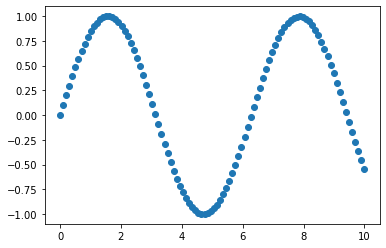

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 生成100个原始数据点
x = np.linspace(0, 10, 100)
y = np.sin(x)

# 初始化插值后的数据点
x_new = np.linspace(0, 10, 1000)
y_new = []

# 对每一对相邻的原始数据点进行随机插值
for i in range(len(x) - 1):
    x_range = x[i:i + 2]
    y_range = y[i:i + 2]

    # 在只有两个点的情况下，只使用线性插值
    method = 'linear'
    
    f = interp1d(x_range, y_range, kind=method)
    x_interp = np.linspace(x_range[0], x_range[1], 10)  # 在每对相邻点之间生成10个新点
    y_interp = f(x_interp)
    
    y_new.extend(y_interp)

# 画图
plt.figure()
plt.scatter(x, y, label='Original Points')
plt.plot(x_new, y_new, label='Interpolated Points')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (90,)

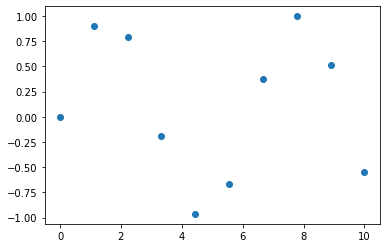

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 生成100个原始数据点
x = np.linspace(0, 10, 10)
y = np.sin(x)

# 初始化插值后的数据点
x_new = np.linspace(0, 10, 1000)
y_new = []

# 对每一对相邻的原始数据点进行随机插值
for i in range(len(x) - 1):
    x_range = x[i:i + 2]
    y_range = y[i:i + 2]

    # 在只有两个点的情况下，只使用线性插值
    method = 'linear'
    
    f = interp1d(x_range, y_range, kind=method)
    x_interp = np.linspace(x_range[0], x_range[1], 10)  # 在每对相邻点之间生成10个新点
    y_interp = f(x_interp)
    
    # 添加随机噪声
    noise = 0.1 * np.random.normal(size=len(y_interp))
    y_interp += noise
    
    y_new.extend(y_interp)

# 画图
plt.figure()
plt.scatter(x, y, label='Original Points')
plt.plot(x_new, y_new, label='Interpolated Points')
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (1000,) and (900,)

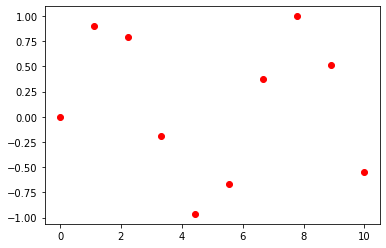

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 生成10个原始数据点
x = np.linspace(0, 10, 10)
y = np.sin(x)

# 初始化插值后的数据点
x_new = np.linspace(0, 10, 1000)
y_new = []

# 对每一对相邻的原始数据点进行随机插值
for i in range(len(x) - 1):
    x_range = x[i:i + 2]
    y_range = y[i:i + 2]

    # 在只有两个点的情况下，只使用线性插值
    method = 'linear'
    
    f = interp1d(x_range, y_range, kind=method)
    x_interp = np.linspace(x_range[0], x_range[1], 100)  # 在每对相邻点之间生成100个新点
    y_interp = f(x_interp)
    
    # 添加随机噪声
    noise = 0.1 * np.random.normal(size=len(y_interp))
    y_interp += noise
    
    y_new.extend(y_interp)

# 画图
plt.figure()
plt.scatter(x, y, label='Original Points', c='red')
plt.plot(x_new, y_new, label='Interpolated Points')
plt.legend()
plt.show()


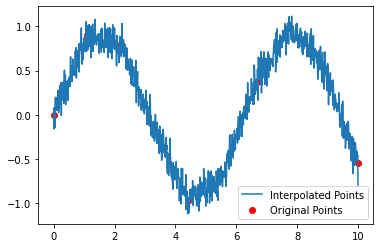

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 生成10个原始数据点
x = np.linspace(0, 10, 10)
y = np.sin(x)

# 初始化插值后的数据点列表
y_new = []

# 对每一对相邻的原始数据点进行随机插值
for i in range(len(x) - 1):
    x_range = x[i:i + 2]
    y_range = y[i:i + 2]

    # 使用线性插值
    method = 'linear'
    
    f = interp1d(x_range, y_range, kind=method)
    x_interp = np.linspace(x_range[0], x_range[1], 111)  # 在每对相邻点之间生成111个新点
    y_interp = f(x_interp)
    
    # 添加随机噪声
    noise = 0.1 * np.random.normal(size=len(y_interp))
    y_interp += noise
    
    # 除了最后一次迭代，去掉每次插值的最后一个点以避免重复
    if i < len(x) - 2:
        y_new.extend(y_interp[:-1])
    else:
        y_new.extend(y_interp)

# 创建新的x轴数据点
x_new = np.linspace(0, 10, len(y_new))

# 画图
plt.figure()
plt.scatter(x, y, label='Original Points', c='red')
plt.plot(x_new, y_new, label='Interpolated Points')
plt.legend()
plt.show()
